# Cancer Doc Classification


For Biomedical text document classification, abstract and full papers(whose length less than or equal to 6 pages) available and used. This dataset focused on long research paper whose page size more than 6 pages.

Dataset includes cancer documents to be classified into 3 categories like'Thyroid_Cancer','Colon_Cancer','Lung_Cancer'.

Total publications=7569.

it has 3 class labels in dataset.
number of samples in each categories:

colon cancer=2579, lung cancer=2180, thyroid cancer=2810

# Install & Setup Libraries

In [1]:
!pip install opendatasets

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import opendatasets as od
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from collections import defaultdict
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

load Dataset

In [5]:
od.download("https://www.kaggle.com/datasets/falgunipatel19/biomedical-text-publication-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mahmoudhusseinkamel
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/falgunipatel19/biomedical-text-publication-classification


100%|██████████| 55.9M/55.9M [00:02<00:00, 23.0MB/s]


In [6]:
PATH =('biomedical-text-publication-classification/alldata_1_for_kaggle.csv')

# Explore Data

In [9]:
data = pd.read_csv(PATH, encoding='latin-1')
data.head()

,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [10]:
data.shape

(7570, 3)

Rename Columns

In [11]:
data.rename(columns= {"0" :"Target" , "a" : "Text"}, inplace = True)

In [12]:
data.head()

,Unnamed: 0,Target,Text
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


Target Unique Values

In [13]:
data['Target'].unique()

array(['Thyroid_Cancer', 'Colon_Cancer', 'Lung_Cancer'], dtype=object)

In [14]:
target_counts= data['Target'].value_counts()
target_counts

Target
Thyroid_Cancer    2810
Colon_Cancer      2580
Lung_Cancer       2180
Name: count, dtype: int64

Target Distribution

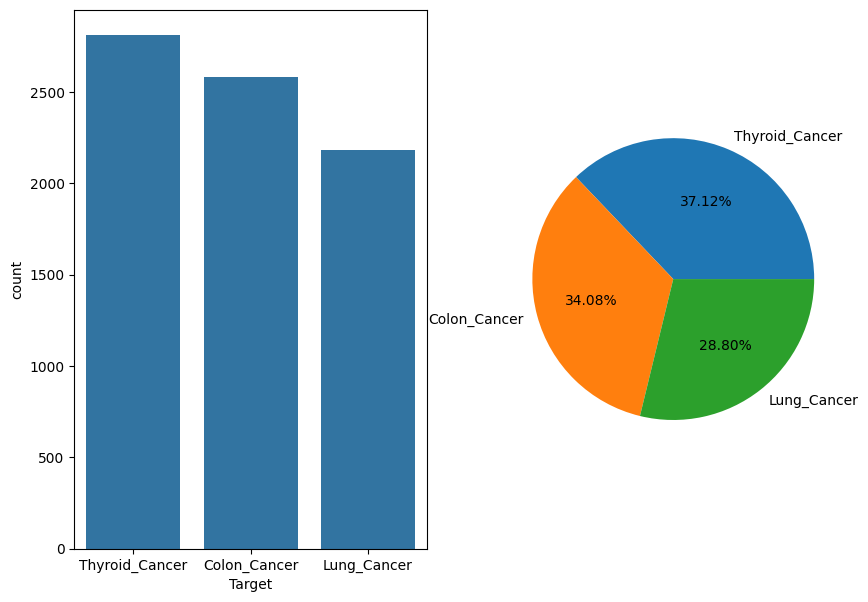

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
sns.barplot(x=target_counts.index, y=target_counts, ax=axes[0])
axes[1].pie(target_counts, labels=target_counts.keys(), autopct='%1.2f%%')
#The pie chart represents the values in target_counts, with each slice labeled using the keys of target_counts
plt.show()

# Distribution for Text Length

In [20]:
# Feature Engineering
data['text_len'] = data['Text'].str.len()
data['word_count'] = data['Text'].apply(lambda x: len(str(x).split()))
data['unique_word_count'] = data['Text'].apply(lambda x: len(set(str(x).split())))
data['stop_word_count'] = data['Text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
data['url_count'] = data['Text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
data['punctuation_count'] = data['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [21]:
data.head()

,Unnamed: 0,Target,Text,text_len,word_count,unique_word_count,stop_word_count,url_count,punctuation_count
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...,20707,2871,1098,814,1,4
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us...",17018,2494,994,815,0,70
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,21622,2954,1384,797,0,7
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,13860,1880,909,556,3,1
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...,23696,3037,1318,887,0,5


In [22]:
def wordcloud(target):
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=2000, height=1000).generate(" ".join(data[data['Target']==target]['Text']))
    plt.figure(1,figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

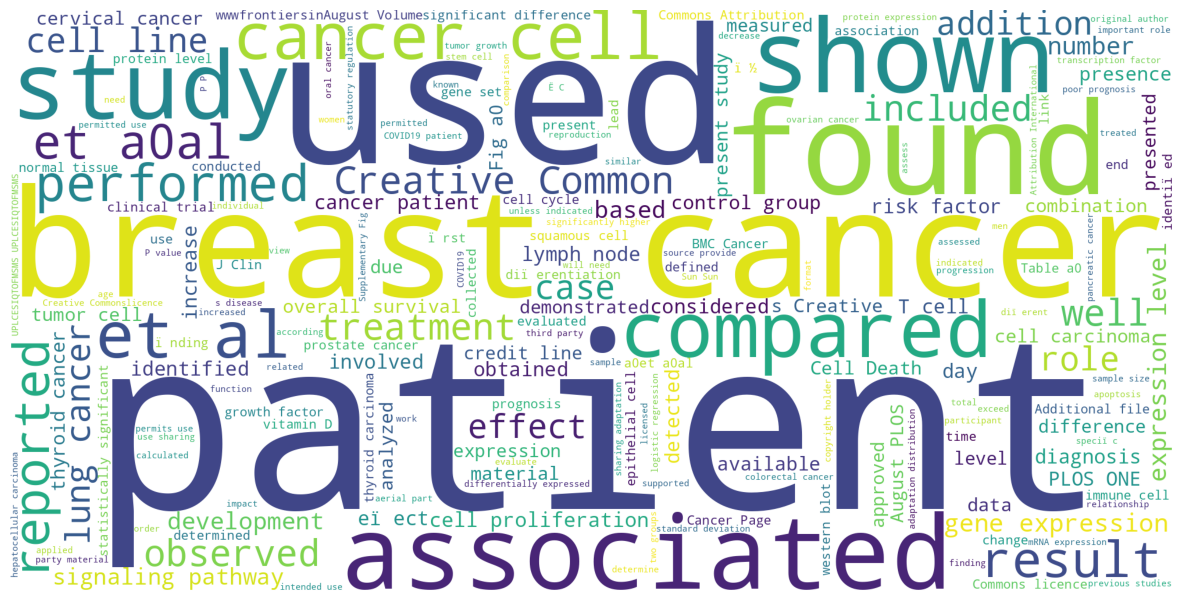

In [23]:
wordcloud('Thyroid_Cancer')

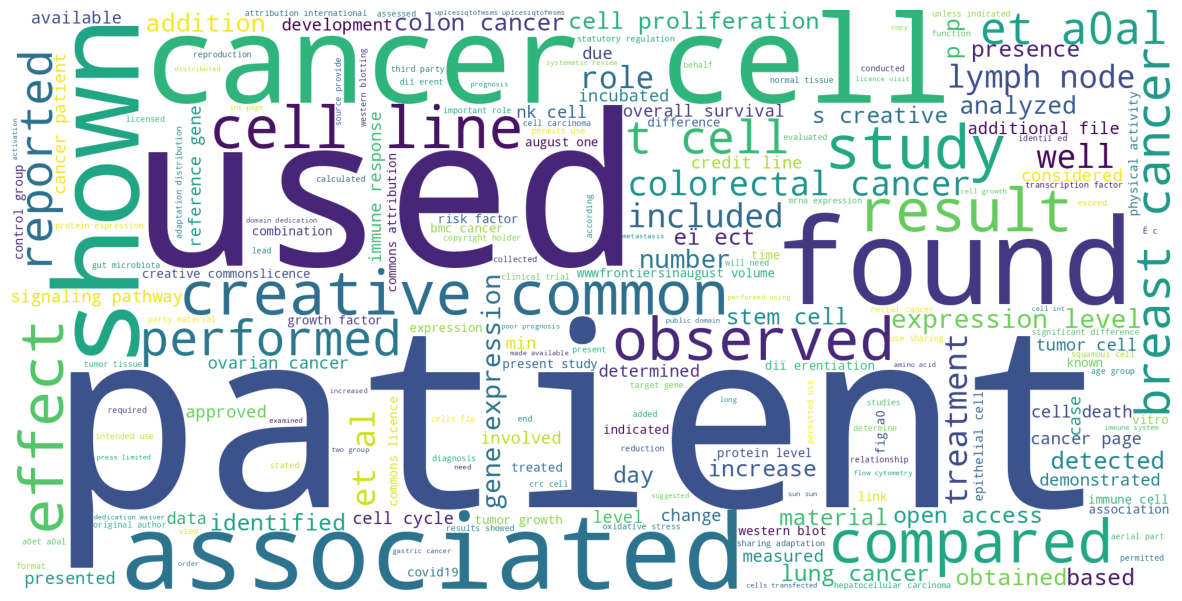

In [24]:
wordcloud('Colon_Cancer')

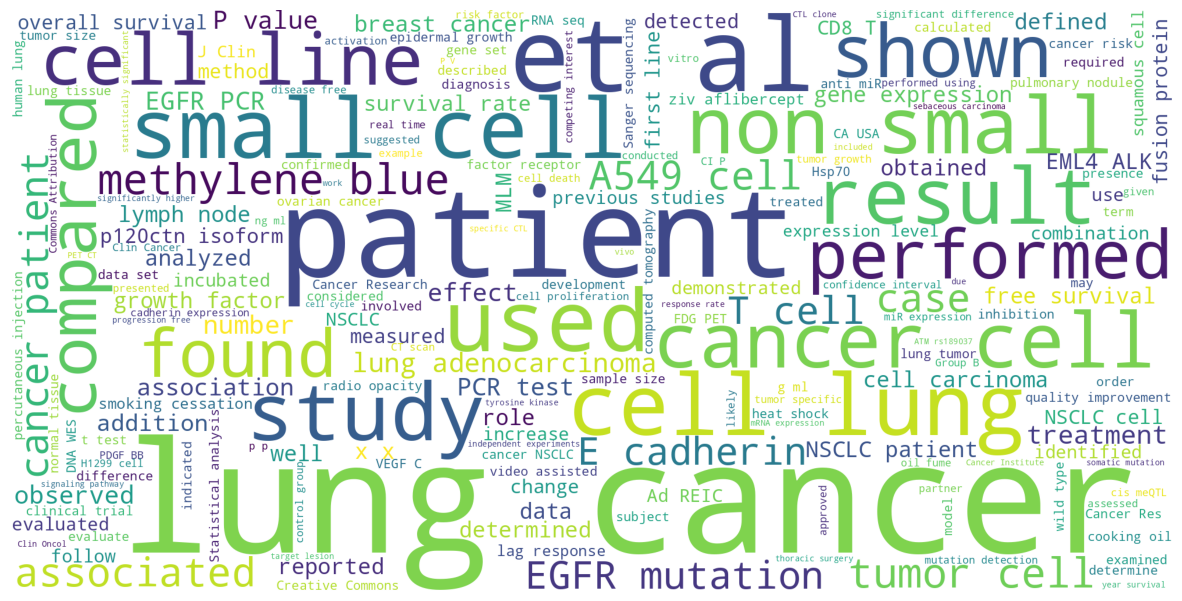

In [25]:
wordcloud('Lung_Cancer')

generate and count unigrams (single words) from documents categorized by cancer type (Thyroid Cancer, Colon Cancer, and Lung Cancer).

It then organizes these counts into sorted data frames

In [28]:
# Function Definition
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS] # convert input text into lower case then split it into words(tokens)based on spaces
    ngrams = zip(*[token[i:] for i in range(n_gram)]) #Creates n-grams from the tokens. For unigrams (n_gram=1), it just returns the tokens.
    return [' '.join(ngram) for ngram in ngrams] #Joins the tokens in each n-gram into a string.
# Setting Up
N = 50
# Unigrams
#Initializes dictionaries (defaultdict(int)) to store unigram counts for each cancer type
Thyroid_Cancer_unigrams = defaultdict(int)
Colon_Cancer_unigrams = defaultdict(int)
Lung_Cancer_unigrams = defaultdict(int)
# Counting Unigrams
for doc in data['Text'][data['Target'] == 'Thyroid_Cancer']:
    for word in generate_ngrams(doc):
        Thyroid_Cancer_unigrams[word] += 1

for doc in data['Text'][data['Target'] == 'Colon_Cancer']:
    for word in generate_ngrams(doc):
        Colon_Cancer_unigrams[word] += 1

for doc in data['Text'][data['Target'] == 'Lung_Cancer']:
    for word in generate_ngrams(doc):
        Lung_Cancer_unigrams[word] += 1

# Sorting and creating DataFrames
# Converts each unigram count dictionary to a list of tuples, sorts them by the counts in descending order ([::-1]), and then converts the sorted list to a pandas DataFrame.
Thyroid_Cancer_unigrams = pd.DataFrame(sorted(Thyroid_Cancer_unigrams.items(), key=lambda x: x[1])[::-1])
Colon_Cancer_unigrams = pd.DataFrame(sorted(Colon_Cancer_unigrams.items(), key=lambda x: x[1])[::-1])
Lung_Cancer_unigrams = pd.DataFrame(sorted(Lung_Cancer_unigrams.items(), key=lambda x: x[1])[::-1])

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


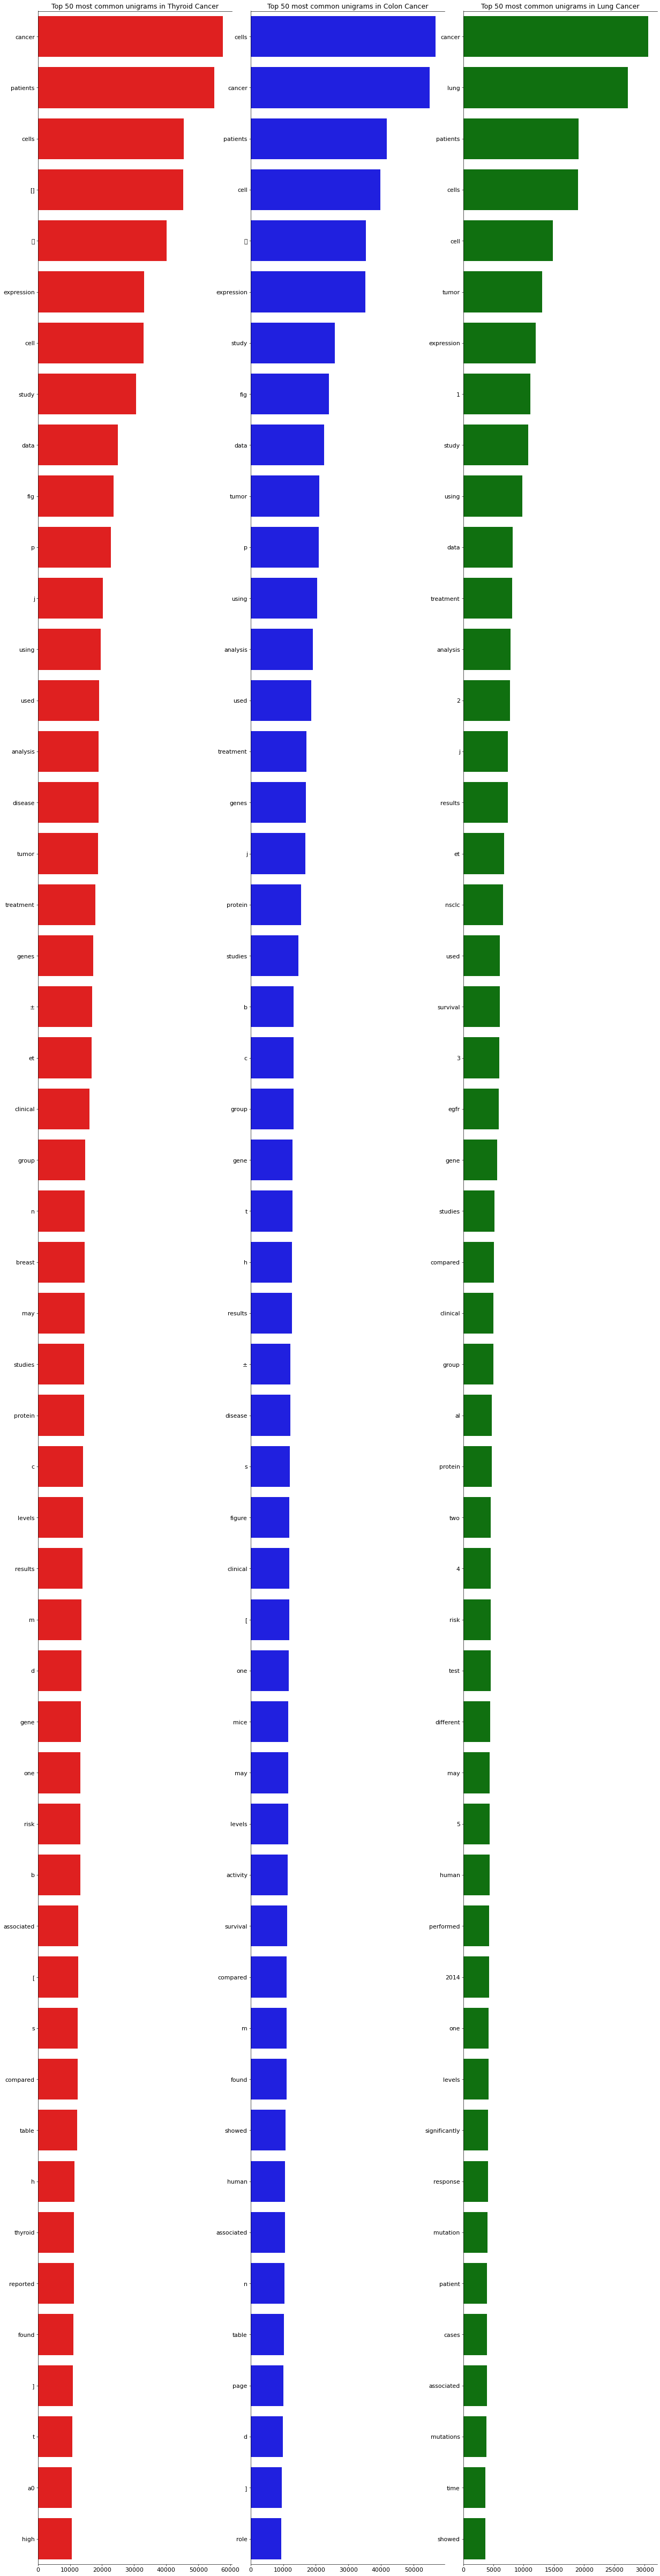

In [29]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 80), dpi=60)
plt.tight_layout()

sns.barplot(y=Thyroid_Cancer_unigrams[0].values[:N], x=Thyroid_Cancer_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=Colon_Cancer_unigrams[0].values[:N], x=Colon_Cancer_unigrams[1].values[:N], ax=axes[1], color='blue')
sns.barplot(y=Lung_Cancer_unigrams[0].values[:N], x=Lung_Cancer_unigrams[1].values[:N], ax=axes[2], color='green')


for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Thyroid Cancer', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Colon Cancer', fontsize=15)
axes[2].set_title(f'Top {N} most common unigrams in Lung Cancer', fontsize=15)

plt.show()

# Data Preprocessing

In [30]:
#Drop the column unnamed as it is not useful:
data.drop('Unnamed: 0',axis=1,inplace= True)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Target             7570 non-null   object
 1   Text               7570 non-null   object
 2   text_len           7570 non-null   int64 
 3   word_count         7570 non-null   int64 
 4   unique_word_count  7570 non-null   int64 
 5   stop_word_count    7570 non-null   int64 
 6   url_count          7570 non-null   int64 
 7   punctuation_count  7570 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 473.2+ KB


In [32]:
data.isna().sum()

Target               0
Text                 0
text_len             0
word_count           0
unique_word_count    0
stop_word_count      0
url_count            0
punctuation_count    0
dtype: int64

In [33]:
#converting into lowercase
data['Text']=data['Text'].str.lower()

In [34]:
#break into words
nltk.download('punkt')
data['Text']=data['Text'].apply(lambda x:word_tokenize(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
#removing special character
def remove_special_char(list):
    y=[]
    for string in list:
        if string.isalnum():
            y.append(string)
    return y
data['Text']=data['Text'].apply(lambda x:remove_special_char(x))

In [36]:
#remove stopwords like is am are and punctuations
def useful_words(list):
    y=[]
    for text in list:
         if text not in stopwords.words('english') and text not in string.punctuation:
                y.append(text)
    return y
data['Text']=data['Text'].apply(lambda x:useful_words(x))

KeyboardInterrupt: 

In [ ]:
#Stemming
stemmer=PorterStemmer()
def stemming(list):
    y=[]
    for text in list:
        y.append(stemmer.stem(text))
    return y
data['Text']=data['Text'].apply(lambda x:stemming(x))

In [37]:
#join the words
data[ 'Text' ] = data[ 'Text' ].apply( lambda   x  : ""  .join( x ))

In [38]:
data

,Target,Text,text_len,word_count,unique_word_count,stop_word_count,url_count,punctuation_count
0,Thyroid_Cancer,thyroidsurgeryinchildreninasingleinstitutionfr...,20707,2871,1098,814,1,4
1,Thyroid_Cancer,theadoptedstrategywasthesameasthatusedinpriory...,17018,2494,994,815,0,70
2,Thyroid_Cancer,coronaryarterybypassgraftingthrombosismutation...,21622,2954,1384,797,0,7
3,Thyroid_Cancer,solitaryplasmacytomaspoftheskullisanuncommoncl...,13860,1880,909,556,3,1
4,Thyroid_Cancer,thisstudyaimedtoinvestigateserummatrixmetallop...,23696,3037,1318,887,0,5
...,...,...,...,...,...,...,...,...
7565,Colon_Cancer,wereportthecaseofa24yearoldmanwhopresentedwith...,11219,1429,660,399,0,11
7566,Colon_Cancer,amongsynchronouscolorectalcancersscrcsreported...,9085,1252,585,388,1,3
7567,Colon_Cancer,theheterogeneityofcancercellsisgenerallyaccept...,32373,4510,1473,1282,0,16
7568,Colon_Cancer,adipogenesisistheprocessthroughwhichmesenchyma...,32390,4051,1407,1281,0,29


# Modeling and Evaluation



In [40]:
#Remove duplicate values to avoid overfitting
data=data.drop_duplicates()

In [41]:
import pickle

#Vectorize the data by using tfidf for text , and y = Target
tfidf=TfidfVectorizer(max_features=4600)
x=tfidf.fit_transform(data['Text']).toarray()
y=data['Target'].values
with open('tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

In [42]:
#Divide the data into  train and test data
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=28,stratify=y)

In [52]:
RandomForestClassifierModel = RandomForestClassifier(criterion = 'gini',n_estimators=300,max_depth=7,random_state=33)
LogisticRegressionModel = LogisticRegression(penalty='l2',solver='sag',C=1.0,random_state=33)
SVCModel = SVC(kernel= 'rbf',max_iter=100,C=1.0,gamma='auto')
DecisionTreeClassifierModel = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=33)
KNNClassifierModel = KNeighborsClassifier(n_neighbors= 5,weights ='uniform',algorithm='auto')
GBCModel = GradientBoostingClassifier(n_estimators=100,max_depth=3,random_state=33)
Models = [KNNClassifierModel,LogisticRegressionModel,RandomForestClassifierModel,
          SVCModel,DecisionTreeClassifierModel,GBCModel]

In [53]:
ModelsScore = {}
for Model in Models :
    print(f'for Model {str(Model).split("(")[0]}')
    Model.fit(X_train, y_train)
    print(f'Train Score is : {Model.score(X_train, y_train)}')
    print(f'Test Score is : {Model.score(X_test, y_test)}')
    y_pred = Model.predict(X_test)
    ClassificationReport = classification_report(y_test,y_pred)
    print('Classification Report is : \n', ClassificationReport )
    print(f'Precision value is  : {ClassificationReport.split()[19]}')
    print(f'Recall value is  : {ClassificationReport.split()[20]}')
    print(f'F1 Score value is  : {ClassificationReport.split()[21]}')
    ModelsScore[str(Model).split("(")[0]] = [ClassificationReport.split()[19],
                                             ClassificationReport.split()[20],ClassificationReport.split()[21]]
    print('=================================================')


for Model KNeighborsClassifier
Train Score is : 0.2677376171352075
Test Score is : 0.26104417670682734


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report is : 
                 precision    recall  f1-score   support

  Colon_Cancer       0.26      1.00      0.41        65
   Lung_Cancer       0.00      0.00      0.00       113
Thyroid_Cancer       0.00      0.00      0.00        71

      accuracy                           0.26       249
     macro avg       0.09      0.33      0.14       249
  weighted avg       0.07      0.26      0.11       249

Precision value is  : accuracy
Recall value is  : 0.26
F1 Score value is  : 249
for Model LogisticRegression
Train Score is : 1.0
Test Score is : 0.4578313253012048
Classification Report is : 
                 precision    recall  f1-score   support

  Colon_Cancer       1.00      0.02      0.03        65
   Lung_Cancer       0.46      1.00      0.63       113
Thyroid_Cancer       0.00      0.00      0.00        71

      accuracy                           0.46       249
     macro avg       0.49      0.34      0.22       249
  weighted avg       0.47      0.46      0.2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Score is : 0.4538152610441767
Test Score is : 0.4538152610441767
Classification Report is : 
                 precision    recall  f1-score   support

  Colon_Cancer       0.00      0.00      0.00        65
   Lung_Cancer       0.45      1.00      0.62       113
Thyroid_Cancer       0.00      0.00      0.00        71

      accuracy                           0.45       249
     macro avg       0.15      0.33      0.21       249
  weighted avg       0.21      0.45      0.28       249

Precision value is  : accuracy
Recall value is  : 0.45
F1 Score value is  : 249
for Model SVC


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299

Train Score is : 0.5542168674698795
Test Score is : 0.2891566265060241


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Classification Report is : 
                 precision    recall  f1-score   support

  Colon_Cancer       1.00      0.02      0.03        65
   Lung_Cancer       0.00      0.00      0.00       113
Thyroid_Cancer       0.29      1.00      0.45        71

      accuracy                           0.29       249
     macro avg       0.43      0.34      0.16       249
  weighted avg       0.34      0.29      0.13       249

Precision value is  : accuracy
Recall value is  : 0.29
F1 Score value is  : 249
for Model DecisionTreeClassifier
Train Score is : 0.4538152610441767
Test Score is : 0.4538152610441767
Classification Report is : 
                 precision    recall  f1-score   support

  Colon_Cancer       0.00      0.00      0.00        65
   Lung_Cancer       0.45      1.00      0.62       113
Thyroid_Cancer       0.00      0.00      0.00        71

      accuracy                           0.45       249
     macro avg       0.15      0.33      0.21       249
  weighted avg       0.21

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Example: Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Addressing class imbalance using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_resampled)

best_rf_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.61
                precision    recall  f1-score   support

  Colon_Cancer       0.00      0.00      0.00        65
   Lung_Cancer       0.45      1.00      0.62       113
Thyroid_Cancer       0.00      0.00      0.00        71

      accuracy                           0.45       249
     macro avg       0.15      0.33      0.21       249
  weighted avg       0.21      0.45      0.28       249



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Deployment

save the model

In [55]:
import joblib

# Save the best model
joblib.dump(best_rf_model, 'best_rf_model.pkl')

['best_rf_model.pkl']

In [57]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [61]:
model = best_rf_model.fit(X_train, y_train)

In [62]:
model.score(X_train, y_train)

0.4538152610441767

In [63]:
# Tokenize the text sample
text = "thyroid surgeri children singl institut osama ibrahim almosallama ali aseerib ahm alhumaida ali alzahran saif alsobhib saud alshanafeybfrom adepart surgeri colleg medicin qassim univers buraidah al qassim saudi arabia bdepart surgeri king faisal specialist hospit research center riyadh saudi arabia cdepart medicin king faisal specialist hospit research center riyadh saudi arabia correspond dr osama ibrahim almosallam depart surgeri colleg medicin qassim univers po box buraidah al qassim saudi arabia orcid orcid0000000290367564 citat almosallam oi aseeri alhumaid alzahrani alsobhi alshanafey thyroid surgeri children singl institut ann saudi med receiv januari accept may publish august copyright copyright annal saudi medicin saudi arabia access creativ common attributionnoncommercialnoderiv intern licens cc byncnd detail access httpcreativecommon licensesbyncnd40fund nonebackground data thyroid surgeri children scarceobject analyz outcom data thyroid surgeri pediatr populationdesign medic record reviewset tertiari health care institutionpati method collect demograph clinic data patient year younger thyroid surgeri period descript data presentedmain outcom measur indic thyroidectomi thyroid patholog complic length stay radioact iodin treatment recurrencessampl size result patient underw thyroidectomi procedur femal mean age oper year associ multipl endocrin neoplasia type histori radiat exposur eightyon patient fine needl aspir fna correl final histopatholog case sixtysix patient malign cancer papillari patient neck dissect lymph node metastasi distant metastas lung procedur includ total thyroidectomi hemithyroidectomi complet subtot thyroidectomi twentythre patient develop hypocalcemia perman unilater recurr laryng nerv injuri perman patient follow mean durat month median month patient thyroid cancer receiv radioact iodin recurr malign commonest indic thyroid surgeri children fna highli diagnost hypocalcemia recurr laryng nerv injuri signific complic recurr rate thyroid cancer limit retrospectiveconflict interest noneorigin ann saudi med julyaugust wwwannsaudimednet 0cthyroid diseas requir surgeri rel uncommon children compar adult preval palpabl thyroid nodul children rang sporad welldifferenti thyroid cancer common endocrin malign children account pediatr cancer prepubert age group cancer adolesc age year2 common indic thyroid surgeri children vari among publish studi thyroidectomi malign condit rising38 data children throughout world rel scarc object studi analyz clinic data outcom thyroid surgeri larg seri children treat singl center king faisal specialist hospit research center kfshrc riyadhpati method approv institut review board irb kfshrc medic record patient year old younger underw thyroid surgeri retrospect review elect includ patient year ensur reason followup period patient studi identifi search oper room log procedur involv thyroid gland specifi age groupdemograph data clinic featur surgic outcom collect specif data obtain includ age oper gender famili histori present symptom histori radiat exposur presenc multipl endocrin neoplasia type men thyroid function test presenc size thyroid nodul ultrasound presenc lymph node metastasi distant metastasi fine needl aspir fna cytolog surgic procedur final histopatholog length followup outcom analyz postop complic includ transient perman hypocalcemia transient perman recurr laryng nerv paralysi wound infect hematoma length stay radioact iodin treatment recurr thyroid procedur seri includ hemithyroidectomi subtot total complet thyroidectomi surgeri perform either endocrin adult surgeon pediatr surgeon intraop nerv monitor use earli seri procedur perform adult endocrin surgeon late combin approach adopt pediatr surgeon adult endocrin surgeon collabor case proceduresth normal rang laboratori regardless symptom transient hypocalcemia identifi last less month perman hypocalcemia consid serum calcium level remain normal rang patient continu calcium supplement month surgeri patient famili histori men underw genet test ret protooncogen confirm diagnosi patient underw complet thyroidectomi preoper postop vocal cord assess otolaryngolog clinic descript data gener comparison conduct use test continu data chisquar fisher exact test proportionsresultsbetween patient underw surgic procedur patient underw two procedur thyroid diseas institut eighti patient femal mean age oper year median year rang year common indic thyroidectomi thyroid nodul present case tabl mean sd size thyroid nodul mm case associ men syndrom final patholog two patient men syndrom show medullari thyroid cancer mtc remain patient prophylact procedur develop mtc none patient histori radiat exposur eightyon patient fna correl final histopatholog case three case toxic adenoma one case diseas requir fna remain case underw fna anoth institut fna repeat institut came complet thyroidectomi document patholog malign first surgeri anoth hospitalth common diagnos includ papillari thyroid cancer multinodular goiter colloid tabl indic thyroidectomi patient indicationnodulen men prophylaxishyperthyroidismmultinodular goitercomplet thyroidectomi hypocalcemia defin calcium level data number origin pediatr thyroid surgeryann saudi med julyaugust wwwannsaudimednet 0cnodul tabl surgic procedur includ total thyroidectomi hemithyroidectomi complet thyroidectomi subtot thyroidectomi neck dissect perform patient oper complic observ patient common complic hypocalcemia transient perman tabl thyroid patholog patientspathologyn benignnorm thyroid tissuecolloid diseasethyroid cancerpapillaryfollicularmedullaryhurthleanaplastictotaldata number tabl benign malign lesion patientsbenignn37malignantn66 p valu age meanyearsgend malefemalepres nodulehypocalcemiarecurr laryng nerv palsybleedinghematomawound infectiontrach injuryoveral complicationsmean length stay daysmen recurr laryng nerv palsi transient perman unilater tabl patient malign lesion lymph node metastasi patient distant metastas lung none patient develop postop bleed wound infect tracheal injuri patient follow mean month median rang month radioact iodin treatment deliv patient malign lesion patient recurr local recurr local distant recurr lung three case receiv radioact iodin rai recurr one case low risk recurr receiv rai recurr one case medullari thyroid cancer receiv rai remain five case clear data whether patient receiv rai recurr local recurr underw resect except one patient lost follow mortal studi discussionth common indic thyroidectomi seri thyroid nodul correl previous publish report pediatr population35 children thyroid nodul estim fourfold higher risk develop thyroid cancer compar adults910 high incid malign seri suggest children thyroid nodul care evaluatedfna valuablemethod preoper evalu thyroid nodul howev limit routin use fna children includ need sedat sampl error limit avail experienc cytopathologists11 mani previou studi report high sensit specif fna evalu thyroid nodul children1114 correl findingsour data show lymph node metastasi thyroid cancer case support notion children thyroid cancer frequent present extens diseas adult lymphnod involv diagnosi seen children compar adult differenti thyroid cancer1523 hospit largest referr center saudi arabia especi oncolog case may explain larg number lymph node distant metastasi cohortth common complic report thyroidectomi children hypoparathyroid incid rang origin pediatr thyroid surgeryann saudi med julyaugust wwwannsaudimednet 0ccorrespond result report hypocalcemia tabl one studi found total thyroidectomi central bilater neck dissect diseas malign risk factor hypocalcemia thyroid surgery3 cohort postop hypocalcemia note malign case fail reach statist signific moreov signific differ benign malign case term mean age gender distribut recurr laryng nerv injuri overal complic find report previously26 multipl studi recent year found invers relationship surgeon volum complic rates2728 similar data pediatr popul lack one studi found highvolum endocrin surgeon better outcom shorter length stay lower cost thyroidectomi parathyroidectomi children compar pediatr surgeon gener surgeon otolaryngologists29 scheumann colleagu also conclud collabor approach pediatr endocrin surgeon would better outcom led author suggest combin approach endocrin pediatr surgeon addit pediatr endocrinologist may optim care children surgic thyroid diseas given low number pediatr patients4 data allow comparison differ approach given late adopt combin approach recurr rate thyroid cancer children thyroidectomi vari wide report studi rang cohort studi explor predictor recurr lymph node involv multipl nodul male gender younger age histolog subtyp advanc tumor stage risk factor associ recurrence17233033 studi patient malign lesion receiv rai although conflict data regard indic postop rai treatment lowrisk patient current recommend lowrisk patient treat without rai3436ther limit studi retrospect natur may affect valid qualiti data small number case categori enabl us compar group explor predictor rel factor hand studi add scarc data thyroid surgeri pediatr age group malign commonest indic thyroid surgeri children fna highli diagnost hypocalcemia recurr laryng nerv injuri signific complic cancerrel death extrem rare recurr uncommon signific number patient malign case receiv rai treatmentorigin pediatr thyroid surgeryann saudi med julyaugust wwwannsaudimednet 0crefer trowbridg fl matovinov j mclaren gd nichaman mz iodin goiter children pediatr rie lag melbert krapcho stinchcomb dg howlad n horner mj et al seer cancer statist review bethesda nation cancer institut base novemb seer data submiss chen h masiako pt gaz rd hodin ra parangi randolph gw et al pediatr thyroidectomi high volum thyroid surgeri center risk factor postop hypocalcemia j pediatr surg aug5081316 wood jh partrick da barham hp bensard dd traver hs bruni jl et al pediatr thyroidectomi collabor surgic approach j pediatr surg may4658238 scholz smith jr chaignaud b shamberg rc huang sa thyroid surgeri hospit boston 35year singleinstitut experi j pediatr surg mar46343742 josefson j zimmerman thyroid nodul cancer children pediatr endocrinol rev sep611423 hame r zacharin mr chang face paediatr adolesc thyroid cancer j paediatr child health lugovicent h ortiz vn irizarri h camp ji v pediatr thyroid nodul manag era fine needl aspirationj pediatr surg mussa de andrea motta mormil palestini n corria predictor malign children thyroid nodul j pediatr oct167488692 amirazodi e propst ej chung ct parra da wasserman jd pediatr thyroid fna biopsi outcom impact manag year tertiari care center cancer cytopathol partyka kl huang ec2 cramer hm chen wu hh histolog clinic followup thyroid fineneedl aspir pediatr patient cancer cytopathol sinha ck decoppi p pierro brain c hindmarsh p butler g et al thyroid surgeri children clinic outcom eur j pediatr surg oct2554259 kundel thompson gb richard ml qiu lx cai schwenk fw et al pediatr endocrin surgeri 20year experi mayo clinic j clin endocrinol metab februari jiang w newburi ro newfield rs pediatr thyroid surgeri manag thyroid nodulesan institut experi featur 10year period int j pediatr endocrinol burk jf sippel rs chen h evolut pediatr thyroid surgeri tertiari medic center surg re alqahtani kh tunio al asiri aljohani nj bayoumi riaz k et al clinicopatholog treatment outcom differenti thyroid cancer saudi children adult j otolaryngol head neck surg nov kluijfhout wp van beek dj verrijn stuart aa lodewijk l valk gd van der zee dc et al postop complic prophylact thyroidectomi young patient multipl endocrin neoplasia type medicin baltimor 20159429e1108 raval mv brown chin ac zimmerman angelo p reynold total thyroidectomi benign diseas pediatr safe j pediatr surg stavraki ai ituart ph ko cy yeh mw surgeon volum predictor outcom inpati outpati endocrin surgeri surgeri sosa ja bowman hm tielsch jm pow nr gordon ta udelsman r import surgeon experi clinic econom outcom thyroidectomi ann surg tuggl ct roman sa wang ts boudouraki l thoma udelsman r et al pediatr endocrin surgeri oper children surgeri dec144686977 park jeong js ryu hr lee c park jh kang et al differenti thyroid carcinoma children adolescents27year experi yonsei univers health system j korean med sci palmer ba zarroug ae poley rn kollar jp moir cr papillari thyroid carcinoma children risk factor complic diseas recurr j pediatr surg wada n sugino k mimura nagahama kitagawa w shibuya h et al pediatr differenti thyroid carcinoma stage risk factor analysi diseas free surviv bmc cancer danes gardini farsetti sciacchitano andreoli pontecorvi thyroid carcinoma children adolesc eur j pediatr astl j chovanec luke p katra r dvorakova vlcek p et al thyroid carcinoma surgeri children adolesc year experi surgeri pediatr thyroid lymph node metastas carcinoma int j pediatr otorhinolaryngol chaukar da rangarajan v nair n nadkarni ms pai ps dcruz ak et al pediatr thyroid cancer j surg oncol dzodic r buta markov gavrilo matov milovanov z et al surgic manag welldifferenti thyroid carcinoma children adolesc year experi singl institut serbia endocr j scheumann gf gimm wegen g hundeshagen h drall h prognost signific surgic manag locoregion papillari thyroid cancer world j surg shi rl qu n yang sw tumor size interpret predict cervic lymph node metastasi use differenti thyroid cancer risk model onco target ther zimmerman hay id gough ir goellner jr ryan jj grant cs et al papillari thyroid carcinoma children adult longterm followup patient conserv treat one institut three decad surgeri collini p mattavelli f pellegrinelli barisella ferrari massimino papillari carcinoma thyroid gland childhood adolesc morpholog subtyp biolog behavior prognosi clinicopatholog studi sporad case treat singl institut 30year period j surg pathol borsonchazot causeret lifant jc augro berger n peix jl predict factor recurr seri children adolesc differenti thyroid cancer world j surg baumgarten hd bauer aj isaza mostoufimoab kazahaya k adzick ns surgic manag pediatr thyroid diseas complic rate thyroidectomi hospit philadelphia highvolum pediatr thyroid center journal pediatr surgeri oct kurzawinski tr de coppi p thyroidectomi children inpediatr surgeri pp springer berlin heidelberg franci g waguespack sg bauer aj angelog p benvenga et al manag guidelin children thyroid nodul differenti thyroid cancer american thyroid associ guidelin task forc pediatr thyroid cancer thyroid volum number origin pediatr thyroid surgeryann saudi med julyaugust wwwannsaudimednet 0c"
txt = pd.Series(text)

tfidf_text = tfidf.transform(txt).toarray()
print(tfidf_text)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [66]:
model.predict(tfidf_text)

array(['Lung_Cancer'], dtype=object)